# Make sure to run this notebook with python keneral = 3.9.5

In [1]:
import torch
import numpy as np
import h5py
from tqdm import tqdm
import time

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.metrics import compute_meandice, compute_hausdorff_distance

from scipy.ndimage import distance_transform_edt as distance
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    Resized
)
from monai.metrics.utils import do_metric_reduction, ignore_background
from monai.utils import MetricReduction

c:\Users\wenbl13\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import monai
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    RandSpatialCropd,
    CropForegroundd,
    CenterSpatialCropd,
    NormalizeIntensityd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    ToTensord
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from tqdm import tqdm_gui

In [3]:
import numpy as np

# Prepare data

## Load data

In [4]:
root_dir = r"C:\Users\wenbl13\Desktop\Wenbo_Timing"
data_dir = os.path.join(root_dir, "Task02_Heart")

## Set up datasets

In [5]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-4], data_dicts[-4:] # train:valid = 16:4

In [6]:
image_size = (96, 96, 96)

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=["image", "label"], spatial_size = image_size),
        # CenterSpatialCropd(keys=["image", "label"], roi_size=image_size),
        ToTensord(keys=["image", "label"]),
     ]
 )
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True),
        Resized(keys=["image", "label"], spatial_size = image_size),
        # CenterSpatialCropd(keys=["image", "label"], roi_size=image_size),
        ToTensord(keys=["image", "label"]),
    ]
)

## Visualize dataset

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


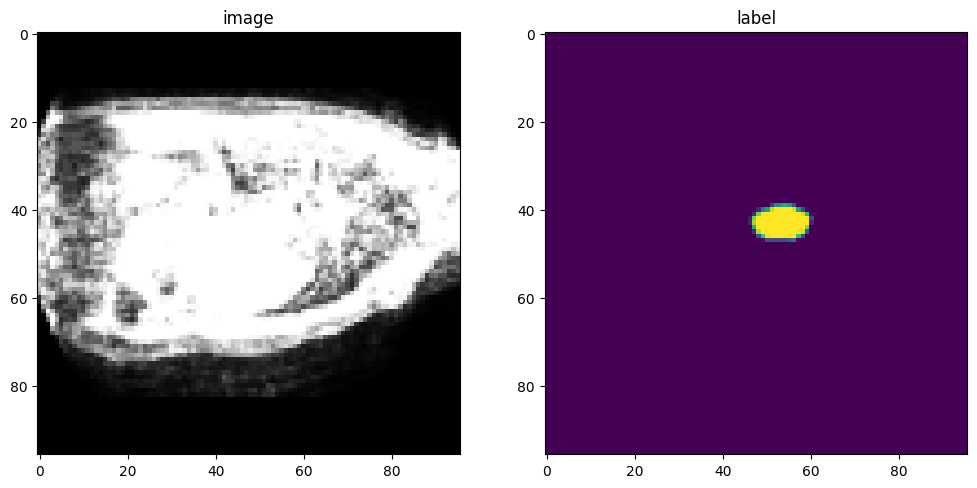

torch.Size([1, 1, 96, 96, 96])


In [8]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 40], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 60])
plt.show()
print(check_data['label'].shape)

## Set up dataloader

In [9]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
     cache_rate=1.0, num_workers=4)
#train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=4, num_workers=4)

val_ds = CacheDataset(
  data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=4, num_workers=4)

100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


## Create 3D U-net, mathing the one in Julia's train loop

In [10]:
def conv(stride, in_dim, out_dim):
    return nn.Conv3d(in_dim, out_dim, kernel_size=3, stride=stride, padding=1)

def tran(stride, in_dim, out_dim):
    return nn.ConvTranspose3d(in_dim, out_dim, kernel_size=3, stride=stride, padding=1, output_padding=1)

def conv1(in_dim, out_dim):
    return nn.Sequential(
        conv(1, in_dim, out_dim),
        nn.BatchNorm3d(out_dim),
        nn.LeakyReLU())

def conv2(in_dim, out_dim):
    return nn.Sequential(
        conv(2, in_dim, out_dim),
        nn.BatchNorm3d(out_dim),
        nn.LeakyReLU())

def conv3(in_dim, out_dim):
    return nn.Sequential(
        conv(1, in_dim, out_dim),
        nn.Softmax(dim=1))
        # nn.Sigmoid())

def tran2(in_dim, out_dim):
    return nn.Sequential(
        tran(2, in_dim, out_dim),
        nn.BatchNorm3d(out_dim),
        nn.LeakyReLU())

def concat(layer1, layer2):
    return torch.cat([layer1, layer2], dim=1)

class unet3D_new(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(unet3D_new, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        # Contracting layers
        self.l1 = conv1(in_dim, 8)
        self.l2 = nn.Sequential(conv2(8, 16), conv1(16, 16))
        self.l3 = nn.Sequential(conv2(16, 32), conv1(32, 32))
        self.l4 = nn.Sequential(conv2(32, 64), conv1(64, 64))
        self.l5 = nn.Sequential(conv2(64, 128), conv1(128, 128))

        # Expanding layers
        self.l6 = tran2(128, 64)
        self.l7 = nn.Sequential(conv1(128, 64), tran2(64, 32))
        self.l8 = nn.Sequential(conv1(64, 32), tran2(32, 16))
        self.l9 = nn.Sequential(conv1(32, 16), tran2(16, 8))
        self.l10 = nn.Sequential(conv3(8, out_dim))

    def forward(self, x):
        # Contracting layers
        l1_out = self.l1(x)
        l2_out = self.l2(l1_out)
        l3_out = self.l3(l2_out)
        l4_out = self.l4(l3_out)
        l5_out = self.l5(l4_out)

        # Expanding layers
        l6_out = self.l6(l5_out)
        l7_out = self.l7(concat(l4_out, l6_out))
        l8_out = self.l8(concat(l3_out, l7_out))
        l9_out = self.l9(concat(l2_out, l8_out))
        out = self.l10(l9_out)

        return out

Test the model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 96
x = torch.Tensor(1, 1, image_size, image_size, image_size)
x.to(device)
print("int size: {}".format(x.size()))

m = unet3D_new(1, 2)

out = m(x)
print("out size: {}".format(out.size()))

int size: torch.Size([1, 1, 96, 96, 96])
out size: torch.Size([1, 2, 96, 96, 96])


## Create loss functions, mathing the ones in Julia's train loop

In [12]:
def dice_loss(pred_mask, mask):
    # target = target.float()
    # smooth = 1e-5
    intersect = torch.sum(torch.mul(pred_mask, mask))
    y_sum = torch.sum(torch.mul(mask, mask))
    z_sum = torch.sum(torch.mul(pred_mask, pred_mask))
    loss = 1 - (2 * intersect + 1e-5) / (z_sum + y_sum + 1e-5)
    return loss

In [13]:
# A working 3D DT
def compute_dtm(img_gt, out_shape):
    """
    compute the distance transform map of foreground in binary mask
    input: segmentation, shape = (batch_size, num_channels, x, y, z)
    output: the foreground Distance Map (SDM) 
    dtm(x) = 0; x in segmentation boundary
             inf|x-y|; x in segmentation
    """

    fg_dtm = np.zeros(out_shape)

    for b in range(out_shape[0]): # each batch
        for c in range(out_shape[1]): # each channel
            # 3D DT
            posmask = img_gt[b][c]
            if posmask.any():
                posdis = distance(1 - posmask)
                fg_dtm[b][c] = posdis

    return fg_dtm

def hd_loss(seg_soft, gt, seg_dtm, gt_dtm):
    """
    compute huasdorff distance loss for binary segmentation
    input: seg_soft: softmax results,  shape=(b,2,x,y,z)
           gt: ground truth, shape=(b,1,x,y,z)
           seg_dtm: segmentation distance transform map; shape=(b,2,x,y,z)
           gt_dtm: ground truth distance transform map; shape=(b,1,x,y,z)
    output: boundary_loss; sclar
    """

    # delta_s = (seg_soft[:,1,...] - gt.float()[:,0,...]) ** 2
    delta_s = (seg_soft[:,1:2,...] - gt) ** 2
    s_dtm = seg_dtm[:,1:2,...] ** 2
    g_dtm = gt_dtm ** 2
    dtm = s_dtm + g_dtm
    multipled = torch.einsum('bcxyz, bcxyz->bcxyz', delta_s, dtm)
    hd_loss = multipled.mean()

    # delta_s = (seg_soft - gt.float()) ** 2
    # s_dtm = seg_dtm** 2
    # g_dtm = gt_dtm ** 2
    # dtm = s_dtm + g_dtm
    # multipled = torch.einsum('xyz, xyz->xyz', delta_s, dtm)
    # hd_loss = multipled.mean()

    return hd_loss

# Train, Loss = Dice

In [14]:
# Losses
time_epoch_dice = []
time_step_dice = []
train_loss_epoch_dice = []
valid_loss_epoch_dice = []
# Metrics
train_metric_epoch_dice = []
valid_metric_epoch_dice = []
train_metric_epoch_hd = []
valid_metric_epoch_hd = []
all_metric_epoch_dice = []
all_metric_epoch_hd = []

device = torch.device("cuda:0")
num_epochs_dice = 250
model_dice = unet3D_new(1, 2).to(device)
optimizer_dice = torch.optim.Adam(model_dice.parameters(), lr= 0.001, weight_decay=0.0001) # lr=0.001, betas=(0.9, 0.999) by default
for epoch_num in range(num_epochs_dice):
    time_curr_opoch = 0
    print(f"epoch #{epoch_num + 1}:")
    step_ct = 0
    # Epoch start
    t1 = time.perf_counter_ns()
    model_dice.train()
    for curr_batch in train_loader:
        # Step start
        img, mask = curr_batch['image'].cuda(), curr_batch['label'].cuda()
        # Clear grad
        optimizer_dice.zero_grad()
        # Forward
        pred_mask = model_dice(img)
        # Loss
        loss = dice_loss(pred_mask[:,1:2,...], mask)
        # Backward
        loss.backward()
        # Optimizing
        optimizer_dice.step()
        # Step end
        t2 = time.perf_counter_ns()
        step_ct += 1
        curr_step_time = t2 - t1
        time_step_dice.append(curr_step_time)
        time_curr_opoch += curr_step_time
        t1 = time.perf_counter_ns()
    # Epoch end
    time_epoch_dice.append(time_curr_opoch)
    model_dice.eval()
    # Reporting data
    train_losses = []
    train_dice_metrics = []
    train_hd_metrics = []
    valid_losses = []
    valid_dice_metrics = []
    valid_hd_metrics = []
    for batch_idx, curr_batch in enumerate(train_loader):
        with torch.no_grad(): # no need to calc grad for validation step
            # Run model
            img, mask = curr_batch['image'].cuda(), curr_batch['label'].cuda()
            pred_mask = model_dice(img)
            # Loss
            loss = dice_loss(pred_mask[:,1:2,...], mask)
            train_losses.append(loss)
            # Metrics
            pred_mask_bi = torch.as_tensor((pred_mask[:,1:2,...] - 0.5) > 0)
            mask_bi = torch.as_tensor((mask - 0.5) > 0)
            dice_m = compute_meandice(y_pred=pred_mask_bi, y=mask_bi)
            hd_m = compute_hausdorff_distance(y_pred=pred_mask_bi, y=mask_bi)
            train_dice_metrics.extend(dice_m)
            train_hd_metrics.extend(hd_m)
    for batch_idx, curr_batch in enumerate(val_loader):
        with torch.no_grad(): # no need to calc grad for validation step
            # Run model
            img, mask = curr_batch['image'].cuda(), curr_batch['label'].cuda()
            pred_mask = model_dice(img)
            # Loss
            loss = dice_loss(pred_mask[:,1:2,...], mask)
            valid_losses.append(loss)
            # Metrics
            pred_mask_bi = torch.as_tensor((pred_mask[:,1:2,...] - 0.5) > 0)
            mask_bi = torch.as_tensor((mask - 0.5) > 0)
            dice_m = compute_meandice(y_pred=pred_mask_bi, y=mask_bi)
            hd_m = compute_hausdorff_distance(y_pred=pred_mask_bi, y=mask_bi)
            valid_dice_metrics.extend(dice_m)
            valid_hd_metrics.extend(hd_m)
    t_l = sum(train_losses) / len(train_losses)
    v_l = sum(valid_losses) / len(valid_losses)
    t_d_m = sum(train_dice_metrics) / len(train_dice_metrics)
    t_h_m = sum(train_hd_metrics) / len(train_hd_metrics)
    v_d_m = sum(valid_dice_metrics) / len(valid_dice_metrics)
    v_h_m = sum(valid_hd_metrics) / len(valid_hd_metrics)
    if (epoch_num + 1) % 25 == 0:
        torch.save(model_dice.state_dict(), "C:/Users/wenbl13/Desktop/Wenbo_Timing/Python_saved_models/Dice_epoch_" + str(epoch_num+1) + ".pth")
    a_d_m = (sum(train_dice_metrics) + sum(valid_dice_metrics)) / (len(train_dice_metrics) + len(valid_dice_metrics))
    a_h_m = (sum(train_hd_metrics) + sum(valid_hd_metrics)) / (len(train_hd_metrics) + len(valid_hd_metrics))
    print(f"\tTrain loss = {t_l}, valid loss = {v_l}, dice metric = {v_d_m.item()}, hd metric = {v_h_m.item()}")
    train_loss_epoch_dice.append(t_l.item())
    valid_loss_epoch_dice.append(v_l.item())
    train_metric_epoch_dice.append(t_d_m.item())
    valid_metric_epoch_dice.append(v_d_m.item())
    train_metric_epoch_hd.append(t_h_m.item())
    valid_metric_epoch_hd.append(v_h_m.item())
    all_metric_epoch_dice.append(a_d_m.item())
    all_metric_epoch_hd.append(a_h_m.item())


epoch #1:
	Train loss = 0.9838005304336548, valid loss = 0.9851151704788208, dice metric = 0.008873764425516129, hd metric = 75.80401973465186
epoch #2:
	Train loss = 0.9833868741989136, valid loss = 0.9847272038459778, dice metric = 0.023777933791279793, hd metric = 75.7777207217336
epoch #3:
	Train loss = 0.981988787651062, valid loss = 0.9834242463111877, dice metric = 0.0, hd metric = 78.70000152177082
epoch #4:
	Train loss = 0.9793962240219116, valid loss = 0.981050431728363, dice metric = 0.0, hd metric = inf
epoch #5:
	Train loss = 0.9683758020401001, valid loss = 0.9719020128250122, dice metric = 0.025260502472519875, hd metric = inf


Inspect result

image shape: torch.Size([4, 1, 96, 96, 96]), mask shape: torch.Size([4, 1, 96, 96, 96])


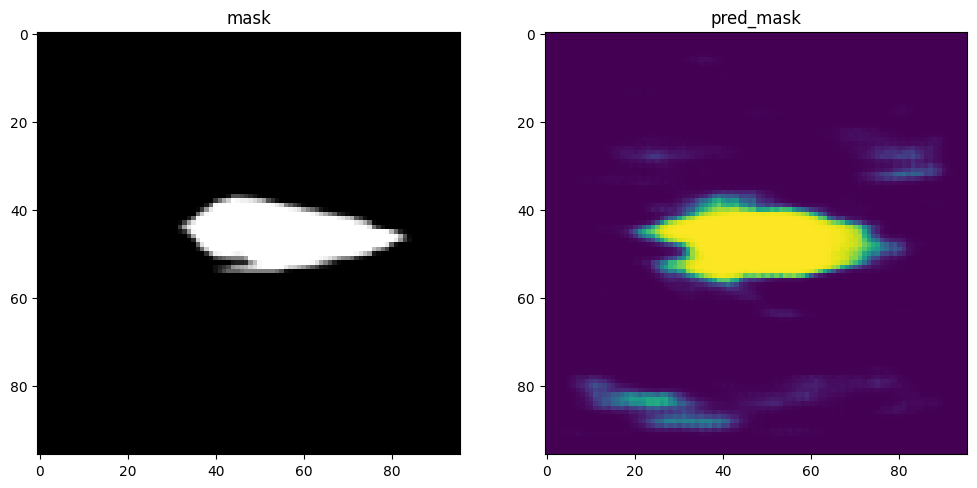

In [15]:
with torch.no_grad():
    channel_idx = 43
    test_data = first(val_loader)
    image, mask = test_data['image'].cuda(), curr_batch['label']
    print(f"image shape: {image.shape}, mask shape: {mask.shape}")
    pred_mask = model_dice(image).cpu()
    
    # plot the slice [:, :, 80]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("mask")
    plt.imshow(mask[0, 0, channel_idx, :, :], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("pred_mask")
    plt.imshow(pred_mask[0, 1, channel_idx, :, :])
    plt.show()

# Train, Loss = Dice+HD

In [15]:
# Losses
time_epoch_dice_hd = []
time_step_dice_hd = []
train_loss_epoch_dice_hd = []
valid_loss_epoch_dice_hd = []
# Metrics
train_metric_epoch_dice2 = []
valid_metric_epoch_dice2 = []
train_metric_epoch_hd2 = []
valid_metric_epoch_hd2 = []
all_metric_epoch_dice2 = []
all_metric_epoch_hd2 = []

device = torch.device("cuda:0")
num_epochs_dice_hd = 250
model_dice_hd = unet3D_new(1, 2).to(device)
optimizer_dice_hd = torch.optim.Adam(model_dice_hd.parameters()) # lr=0.001, betas=(0.9, 0.999) by default
for epoch_num in range(num_epochs_dice_hd):
    time_curr_opoch = 0
    print(f"epoch #{epoch_num + 1}")
    step_ct = 0
    # Epoch start
    t1 = time.perf_counter_ns()
    alpha = (epoch_num+1) * 0.001
    model_dice_hd.train()
    for curr_batch in train_loader:
        # Step start
        img, mask = curr_batch['image'].cuda(), curr_batch['label'].cuda()
        # Clear grad
        optimizer_dice_hd.zero_grad()
        # Forward
        pred_mask = model_dice_hd(img)
        # Loss
        with torch.no_grad():
            pred_mask_bi = torch.as_tensor((pred_mask - 0.5) > 0, dtype=torch.float32)
            mask_bi = torch.as_tensor((mask - 0.5) > 0, dtype=torch.float32)
            pred_mask_dtm = torch.from_numpy(compute_dtm(pred_mask_bi.cpu(), (4,2,96,96,96))).cuda()
            mask_dtm = torch.from_numpy(compute_dtm(mask_bi.cpu(), (4,1,96,96,96))).cuda()
        loss_hd = hd_loss(pred_mask, mask, pred_mask_dtm, mask_dtm)
        loss_dice = dice_loss(pred_mask[:,1:2,...], mask)
        loss = alpha * loss_hd + (1 - alpha) * loss_dice
        # Backward
        loss.backward()
        # Optimizing
        optimizer_dice_hd.step()
        # Step end
        t2 = time.perf_counter_ns()
        curr_step_time = t2 - t1
        time_step_dice_hd.append(curr_step_time)
        time_curr_opoch += curr_step_time
        step_ct += 1
        t1 = time.perf_counter_ns()
    # Epoch end
    time_epoch_dice_hd.append(time_curr_opoch)
    # Evaluation step
    model_dice_hd.eval()
    # Reporting data
    train_losses = []
    train_dice_metrics = []
    train_hd_metrics = []
    valid_losses = []
    valid_dice_metrics = []
    valid_hd_metrics = []
    for curr_batch in train_loader:
        with torch.no_grad(): # no need to calc grad for validation step
            # Run model
            img, mask = curr_batch['image'].cuda(), curr_batch['label'].cuda()
            pred_mask = model_dice_hd(img)
            # Losses
            pred_mask_bi = torch.as_tensor((pred_mask - 0.5) > 0, dtype=torch.float32)
            mask_bi = torch.as_tensor((mask - 0.5) > 0, dtype=torch.float32)

            pred_mask_dtm = torch.from_numpy(compute_dtm(pred_mask_bi.cpu(), (4,2,96,96,96))).cuda()
            mask_dtm = torch.from_numpy(compute_dtm(mask_bi.cpu(), (4,1,96,96,96))).cuda()
            loss_hd = hd_loss(pred_mask, mask, pred_mask_dtm, mask_dtm)
            loss_dice = dice_loss(pred_mask[:,1:2,...], mask)
            loss = alpha * loss_hd + (1 - alpha) * loss_dice
            train_losses.append(loss)
            # Metrics 
            dice_m = compute_meandice(y_pred=pred_mask_bi[:,1:2,...], y=mask_bi)
            hd_m = compute_hausdorff_distance(y_pred=pred_mask_bi[:,1:2,...], y=mask_bi)
            train_dice_metrics.extend(dice_m)
            train_hd_metrics.extend(hd_m)
    for curr_batch in val_loader:
        with torch.no_grad(): # no need to calc grad for validation step
            # Run model
            img, mask = curr_batch['image'].cuda(), curr_batch['label'].cuda()
            pred_mask = model_dice_hd(img)
            # Losses
            pred_mask_bi = torch.as_tensor((pred_mask - 0.5) > 0, dtype=torch.float32)
            mask_bi = torch.as_tensor((mask - 0.5) > 0, dtype=torch.float32)

            pred_mask_dtm = torch.from_numpy(compute_dtm(pred_mask.cpu(), (4,2,96,96,96))).cuda()
            mask_dtm = torch.from_numpy(compute_dtm(mask.cpu(), (4,1,96,96,96))).cuda()
            loss_hd = hd_loss(pred_mask, mask, pred_mask_dtm, mask_dtm)
            loss_dice = dice_loss(pred_mask[:,1:2,...], mask)
            loss = alpha * loss_hd + (1 - alpha) * loss_dice
            valid_losses.append(loss)
            # Metrics 
            dice_m = compute_meandice(y_pred=pred_mask_bi[:,1:2,...], y=mask_bi)
            hd_m = compute_hausdorff_distance(y_pred=pred_mask_bi[:,1:2,...], y=mask_bi)
            valid_dice_metrics.extend(dice_m)
            valid_hd_metrics.extend(hd_m)
    t_l = sum(train_losses) / len(train_losses)
    v_l = sum(valid_losses) / len(valid_losses)
    t_d_m = sum(train_dice_metrics) / len(train_dice_metrics)
    t_h_m = sum(train_hd_metrics) / len(train_hd_metrics)
    v_d_m = sum(valid_dice_metrics) / len(valid_dice_metrics)
    v_h_m = sum(valid_hd_metrics) / len(valid_hd_metrics)
    if (epoch_num + 1) % 25 == 0:
        torch.save(model_dice_hd.state_dict(), "C:/Users/wenbl13/Desktop/Wenbo_Timing/Python_saved_models/HD_Dice_epoch_" + str(epoch_num+1) + ".pth")
    a_d_m = (sum(train_dice_metrics) + sum(valid_dice_metrics)) / (len(train_dice_metrics) + len(valid_dice_metrics))
    a_h_m = (sum(train_hd_metrics) + sum(valid_hd_metrics)) / (len(train_hd_metrics) + len(valid_hd_metrics))
    print(f"\tTrain loss = {t_l}, valid loss = {v_l}, dice metric = {v_d_m.item()}, hd metric = {v_h_m.item()}")
    train_loss_epoch_dice_hd.append(t_l.item())
    valid_loss_epoch_dice_hd.append(v_l.item())
    train_metric_epoch_dice2.append(t_d_m.item())
    valid_metric_epoch_dice2.append(v_d_m.item())
    train_metric_epoch_hd2.append(t_h_m.item())
    valid_metric_epoch_hd2.append(v_h_m.item())
    all_metric_epoch_dice2.append(a_d_m.item())
    all_metric_epoch_hd2.append(a_h_m.item())


epoch #1
	Train loss = 1.3355339075634942, valid loss = 3.707057492186721, dice metric = 0.007247524335980415, hd metric = 76.10025957105508
epoch #2
	Train loss = 2.4467752619347243, valid loss = 5.86909817784142, dice metric = 0.0, hd metric = 76.10025957105508
epoch #3
	Train loss = 5.2478702854419454, valid loss = 7.05221225496254, dice metric = 0.0, hd metric = 77.54459532822058
epoch #4
	Train loss = 2.063650297711103, valid loss = 7.828904573232781, dice metric = 0.03566164895892143, hd metric = 38.70905439989521
epoch #5
	Train loss = 2.676431881643869, valid loss = 4.623503568871062, dice metric = 0.0, hd metric = 62.170428997187486


Inspect result

image shape: torch.Size([4, 1, 96, 96, 96]), mask shape: torch.Size([4, 1, 96, 96, 96])


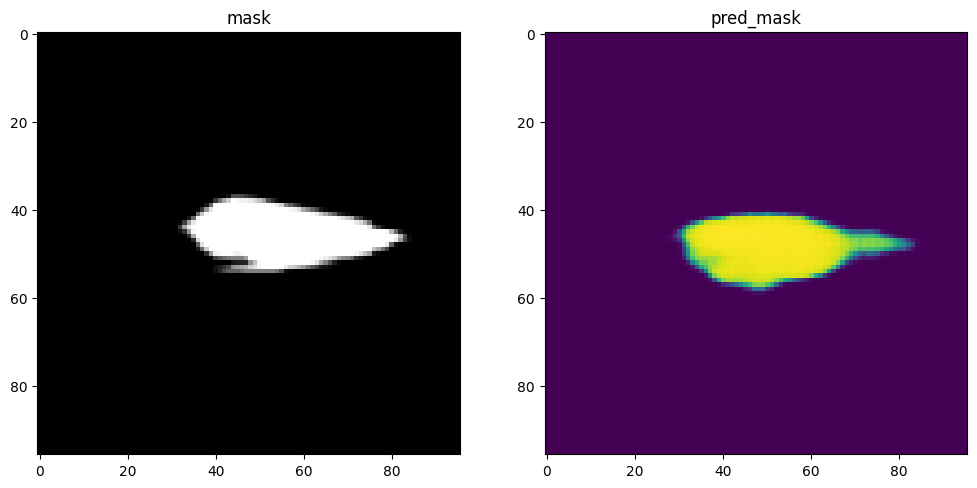

In [17]:
with torch.no_grad():
    channel_idx = 43
    test_data = first(val_loader)
    image, mask = test_data['image'].cuda(), curr_batch['label']
    print(f"image shape: {image.shape}, mask shape: {mask.shape}")
    pred_mask = model_dice_hd(image).cpu()
    # plot the slice [:, :, 80]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("mask")
    plt.imshow(mask[0, 0, channel_idx, :, :], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("pred_mask")
    plt.imshow(pred_mask[0, 1, channel_idx, :, :])
    plt.show()

# Save to CSVs
- Time per epoch:  
    `time_epoch_dice` and `time_epoch_dice_hd`. size = 250

- Time per step:  
    `time_step_dice` and `time_step_dice_hd`. size = 250*4

- Train loss per epoch:  
    `train_loss_epoch_dice` and `train_loss_epoch_dice_hd` size = 250
    
- Valid loss per epoch:  
    `valid_loss_epoch_dice` and `valid_loss_epoch_dice_hd` size = 250

- Dice matrics:  
    - `train_metric_epoch_dice`: This is the mean dice metric over the [**train set**], when training with [**loss = Dice**]. size = 250
    - `valid_metric_epoch_dice`: This is the mean dice metric over the [**valid set**], when training with [**loss = Dice**]. size = 250
    - `all_metric_epoch_dice`: This is the mean dice metric over the [**train and valid set**], when training with [**loss = Dice**]. size = 250 

    - `train_metric_epoch_dice2`: This is the mean dice metric over the [**train set**], when training with [**loss = Dice + HD**]. size = 250
    - `valid_metric_epoch_dice2`: This is the mean dice metric over the [**valid set**], when training with [**loss = Dice + HD**]. size = 250
    - `all_metric_epoch_dice2`: This is the mean dice metric over the [**train and valid set**], when training with [**loss = Dice + HD**]. size = 250

- HD matrics:  
    - `train_metric_epoch_hd`: This is the mean hd metric over the [**train set**], when training with [**loss = Dice**]. size = 250
    - `valid_metric_epoch_hd`: This is the mean hd metric over the [**valid set**], when training with [**loss = Dice**]. size = 250
    - `all_metric_epoch_hd`: This is the mean hd metric over the [**train and valid set**], when training with [**loss = Dice**]. size = 250

    - `train_metric_epoch_hd2`: This is the mean hd metric over the [**train set**], when training with [**loss = Dice + HD**]. size = 250
    - `valid_metric_epoch_hd2`: This is the mean hd metric over the [**valid set**], when training with [**loss = Dice + HD**]. size = 250
    - `all_metric_epoch_hd2`: This is the mean hd metric over the [**train and valid set**], when training with [**loss = Dice + HD**]. size = 250

In [18]:
# save above data to CSVs
epoch_time_df = {"time_epoch_dice" : time_epoch_dice, "time_epoch_dice_hd" : time_epoch_dice_hd }
step_time_df = {"time_step_dice" : time_step_dice, "time_step_dice_hd" : time_step_dice_hd }
loss_df = {"train_loss_epoch_dice": train_loss_epoch_dice, "train_loss_epoch_dice_hd": train_loss_epoch_dice_hd, 
"valid_loss_epoch_dice" : valid_loss_epoch_dice, "valid_loss_epoch_dice_hd": valid_loss_epoch_dice_hd}
dice_metric_df = {"train_metric_epoch_dice":train_metric_epoch_dice, "valid_metric_epoch_dice":valid_metric_epoch_dice, "all_metric_epoch_dice" : all_metric_epoch_dice, 
"train_dice_metric_epoch_dice_hd" : train_metric_epoch_dice2, "valid_dice_metric_epoch_dice_hd" : valid_metric_epoch_dice2, "all_dice_metric_epoch_dice_hd":all_metric_epoch_dice2}
hd_metric_df = {"train_metric_epoch_hd":train_metric_epoch_hd, "valid_metric_epoch_hd":valid_metric_epoch_hd, "all_metric_epoch_hd" : all_metric_epoch_hd, 
"train_hd_metric_epoch_dice_hd" : train_metric_epoch_hd2, "valid_hd_metric_epoch_dice_hd" : valid_metric_epoch_hd2, "all_hd_metric_epoch_dice_hd":all_metric_epoch_hd2}

In [22]:
epoch_loss_df = {"train_loss_epoch_dice" : train_loss_epoch_dice, "train_loss_epoch_dice_hd" : train_loss_epoch_dice_hd,
"valid_loss_epoch_dice" : valid_loss_epoch_dice, "valid_loss_epoch_dice_hd" : valid_loss_epoch_dice_hd }

In [19]:
import pandas as pd

In [23]:
dataframe_epoch = pd.DataFrame(epoch_time_df)
dataframe_step = pd.DataFrame(step_time_df)
dataframe_dice = pd.DataFrame(dice_metric_df)
dataframe_hd = pd.DataFrame(hd_metric_df)
dataframe_loss = pd.DataFrame(epoch_loss_df)

In [24]:
dataframe_epoch.to_csv("C:/Users/wenbl13/Desktop/Ashwin-Timing/distance-transforms/Python_loop_epoch_time_jan8.csv")
dataframe_step.to_csv("C:/Users/wenbl13/Desktop/Ashwin-Timing/distance-transforms/Python_loop_step_time_jan8.csv")
dataframe_dice.to_csv("C:/Users/wenbl13/Desktop/Ashwin-Timing/distance-transforms/Python_loop_dice_metric_jan8.csv")
dataframe_hd.to_csv("C:/Users/wenbl13/Desktop/Ashwin-Timing/distance-transforms/Python_loop_hd_metric_jan8.csv")
dataframe_loss.to_csv("C:/Users/wenbl13/Desktop/Ashwin-Timing/distance-transforms/Python_loop_loss_jan8.csv")

1. mask(from dataset) and pred_mask(from output of NN)
2. Binarize mask and pred_mask. i.e rounding every values to 0 or 1
3. Edge detection(for 2D). Surface detection(for 3D).
4. throw the pred_mask_surface and mask_surface to matrics calculaters.